# Synthetic Data Generation

We will use a pre-tuned model to produce data. The model output should be a 3D array with condition, signaling node and time point for dimensions. The model output will be sub-sampled to produce the synthetic dataset.

In [1]:
import torch
import numpy
import LEMBAS_generator.bionetwork as bionetwork
import LEMBAS_generator.activationFunctions as activationFunctions
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
from scipy.stats import pearsonr, zscore

## Run the pre-trained model

Run pre-trained model to produce synthetic data that are going to be used to evaluate the toy model. We will store both `fullYfull` which is the Y for all model states as well as the `X` that we used.

Prepare `X` and `fullYFull` for sub-sampling. `X` should be a matrix with Drug and Cell line as indexes and Targeted genes as columns. `fullYFull` should be matrix with Drug, Cell line, and Gene as indexes and Time points as columns.

The Cell line is also simulated by randomizing the bias randomly for each cell line and then run the model. We store the b_cell term for each generation and then pass it to the children cell lines. In the end we store both the b_cell and X_ss (steady state) for each cell line to use it later on or the proper encoding of the cell line in the synthetic data.

In [2]:
# Setup parameters
N = 100
inputAmplitude = 3
projectionAmplitude = 1.2
seed = 123
torch.manual_seed(seed)
numpy.random.seed(seed)

# Cell type spliting parameters
n_celllines = 6
celltype_percent = 0.05
split_1 = 2
split_2 = 2
split_3 = 2

# Load network
networkList, nodeNames, modeOfAction = bionetwork.loadNetwork('data/KEGGnet-Model.tsv')
annotation = pandas.read_csv('data/KEGGnet-Annotation.tsv', sep='\t')
bionetParams = bionetwork.trainingParameters(iterations = 150, clipping=1, leak=0.01)

inName = annotation.loc[annotation['ligand'],'code'].values
outName = annotation.loc[annotation['TF'],'code'].values
inName = numpy.intersect1d(nodeNames, inName)
outName = numpy.intersect1d(nodeNames, outName)

synthetic_data_combined = []
X_combined = []
b_celltype_list = []
xhat_ss_list = []

# Generate input drug data - Only control
torch.manual_seed(123)
X_control = torch.zeros(N, len(inName), dtype=torch.double)

# Generate data for 6 different cell lines
# Calculate cell line specific biases
cnt = 0  # cell line counter
# Generate first gen
for j in range(split_1):
    celltype = cnt
    parameterizedModel = bionetwork.model(networkList, nodeNames, modeOfAction, inputAmplitude, projectionAmplitude, inName, outName, bionetParams, celltype=celltype, celltype_percent=celltype_percent, b_celltype_old = None)
    parameterizedModel = bionetwork.loadParam('data/equationParams.txt', parameterizedModel, nodeNames)

    Y, YfullRef, fullYFull, b_celltype_array_1 = parameterizedModel(X_control)

    # Generate second gen
    for k in range(split_2):
        celltype = cnt
        parameterizedModel = bionetwork.model(networkList, nodeNames, modeOfAction, inputAmplitude, projectionAmplitude, inName, outName, bionetParams, celltype=celltype, celltype_percent=celltype_percent, b_celltype_old = b_celltype_array_1)
        parameterizedModel = bionetwork.loadParam('data/equationParams.txt', parameterizedModel, nodeNames)

        Y, YfullRef, fullYFull, b_celltype_array_2 = parameterizedModel(X_control)
        # Generate third gen
        for l in range(split_3):
            cell_line_name = f"CL{cnt}"
            celltype = cnt
            parameterizedModel = bionetwork.model(networkList, nodeNames, modeOfAction, inputAmplitude, projectionAmplitude, inName, outName, bionetParams, celltype=celltype, celltype_percent=celltype_percent, b_celltype_old = b_celltype_array_2)
            parameterizedModel = bionetwork.loadParam('data/equationParams.txt', parameterizedModel, nodeNames)

            Y, YfullRef, fullYFull, b_celltype_array = parameterizedModel(X_control)
            YfullRef = YfullRef.detach()
            
            xhat_ss = YfullRef.T.numpy()
            b_celltype_list.append(b_celltype_array)
            xhat_ss_list.append(xhat_ss)
            
            cnt += 1


# Generate input drug data
torch.manual_seed(123)
X = torch.zeros(N, len(inName), dtype=torch.double)
for i in range(1, N):  # Skip 0 to include a control sample i.e. zero input
    perturb = torch.rand(1, dtype=torch.double)
    X[i, (i-1) % len(inName)] = perturb  # Stimulate each receptor at least once
    for j in range(0, 2):
        X[i, numpy.random.randint(0, len(inName))] = perturb  #torch.rand(1, dtype=torch.double)

# Create cell lines with pre-calculated bias
cnt = 0
for i in range(len(b_celltype_list)):
    bias = b_celltype_list[i]
    xhat_ss = xhat_ss_list[i]
    cell_line_name = f"CL{cnt}"
    celltype = cnt

    parameterizedModel = bionetwork.model(networkList, nodeNames, modeOfAction, inputAmplitude, projectionAmplitude, inName, outName, bionetParams, celltype=celltype, celltype_percent=celltype_percent, b_celltype_old = None, b_celltype = bias, xhat_0 = xhat_ss)
    parameterizedModel = bionetwork.loadParam('data/equationParams.txt', parameterizedModel, nodeNames)
    
    Y, YfullRef, fullYFull, b_celltype_array = parameterizedModel(X)
    fullYFull = fullYFull.detach()

    # Transform fullYFull to a dataframe
    fullYFull_np = fullYFull.numpy()  # dimensions: conditions, node names, states

    dim1, dim2, dim3 = fullYFull_np.shape

    reshaped_array = fullYFull_np.reshape(dim1 * dim2, dim3)

    synthetic_data = pandas.DataFrame(reshaped_array)

    drug_names = ['DMSO'] + [f"D{i}" for i in range(1, dim1)]
    index = pandas.MultiIndex.from_product([drug_names, [cell_line_name], nodeNames], names=['Drug', 'Cell_line', 'Signaling Node'])
    synthetic_data.index = index

    synthetic_data_combined.append(synthetic_data)
            
    # Transform X to a dataframe
    X_array = X.numpy()
    X_df = pandas.DataFrame(X_array)
    index = pandas.MultiIndex.from_product([drug_names, [cell_line_name]], names=['Drug', 'Cell_line'])
    X_df.index = index
    X_df.columns = inName
    X_combined.append(X_df)
            
    cnt += 1
                    
synthetic_data = pandas.concat(synthetic_data_combined)
X = pandas.concat(X_combined)

# Randomly sub-sample the cell lines
selected_cell_lines = ['CL0', 'CL1', 'CL3', 'CL4', 'CL5', 'CL6']
synthetic_data = synthetic_data[synthetic_data.index.get_level_values('Cell_line').isin(selected_cell_lines)]
X = X[X.index.get_level_values('Cell_line').isin(selected_cell_lines)]

display(synthetic_data.head())
display(X.head())

0         1         2         3    \
Drug Cell_line Signaling Node                                           
DMSO CL0       O00206         -0.000015 -0.000015 -0.000015 -0.000015   
               O14492          0.020825  0.020825  0.020825  0.020825   
               O14511          0.011471  0.011471  0.011471  0.011471   
               O14640         -0.000306 -0.000306 -0.000306 -0.000306   
               O14727         -0.000004 -0.000004 -0.000004 -0.000004   

                                    4         5         6         7    \
Drug Cell_line Signaling Node                                           
DMSO CL0       O00206         -0.000015 -0.000015 -0.000015 -0.000015   
               O14492          0.020825  0.020825  0.020825  0.020825   
               O14511          0.011471  0.011471  0.011471  0.011471   
               O14640         -0.000306 -0.000306 -0.000306 -0.000306   
               O14727         -0.000004 -0.000004 -0.000004 -0.000004   

                                    8         9    ...       140       141  \
Drug Cell_line Signaling Node                      ...                       
DMSO CL0       O00206         -0.000015 -0.000015  ... -0.000015 -0.000015   
               O14492          0.020825  0.020825  ...  0.020825  0.020825   
               O14511          0.011471  0.011471  ...  0.011471  0.011471   
               O14640         -0.000306 -0.000306  ... -0.000306 -0.000306   
               O14727         -0.000004 -0.000004  ... -0.000004 -0.000004   

                                    142       143       144       145  \
Drug Cell_line Signaling Node                                           
DMSO CL0       O00206         -0.000015 -0.000015 -0.000015 -0.000015   
               O14492          0.020825  0.020825  0.020825  0.020825   
               O14511          0.011471  0.011471  0.011471  0.011471   
               O14640         -0.000306 -0.000306 -0.000306 -0.000306   
               O14727         -0.000004 -0.000004 -0.000004 -0.000004   

                                    146       147       148       149  
Drug Cell_line Signaling Node                                          
DMSO CL0       O00206         -0.000015 -0.000015 -0.000015 -0.000015  
               O14492          0.020825  0.020825  0.020825  0.020825  
               O14511          0.011471  0.011471  0.011471  0.011471  
               O14640         -0.000306 -0.000306 -0.000306 -0.000306  
               O14727         -0.000004 -0.000004 -0.000004 -0.000004  

[5 rows x 150 columns]

,,O14511,O14788,O14944,O43557,O75093,O75094,O75326,O94813,O96014,P00734,...,Q8NHW4,Q8WWG1,Q96A98,Q96B86,Q96S42,Q99075,Q9GZV9,Q9NPF7,Q9NSA1,Q9NT99
Drug,Cell_line,,,,,,,,,,,,,,,,,,,,,
DMSO,CL0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
D1,CL0,0.368896,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.368896,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
D2,CL0,0.000000,0.013366,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.013366,0.0,0.0
D3,CL0,0.000000,0.000000,0.59178,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
D4,CL0,0.000000,0.000000,0.00000,0.092639,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.092639,0.000000,0.0,0.0


In [3]:
# Check if control is properly created with all columns 0 in X
filtered_rows = X.loc['DMSO']
all_zeros = (filtered_rows == 0).all().all()
print("All columns of the rows with Drug 'DMSO' (control) are all zeros:", all_zeros)

All columns of the rows with Drug 'DMSO' (control) are all zeros: True


## Simulate Phosphosites

In [ ]:
def simulate_sites(df):
    """
    Simulate phosphosites by applying random number of random weights on the signaling node values.
    
    Args:
        df (pandas.DataFrame): The input DataFrame.
    
    Returns:
        pandas.DataFrame: The DataFrame with the simulated sites
    """
    df = df.reset_index()
    result_df = pandas.DataFrame()
    
    time_step_columns = [col for col in df.columns if col not in ['Drug', 'Cell_line', 'Signaling Node']]

    for node in df['Signaling Node'].unique():
        node_df = df[df['Signaling Node'] == node].copy()

        # Determine the number of sites for this node based on an exponential distribution
        num_sites = numpy.random.exponential(scale=1.5)
        num_sites = 1 #max(1, int(numpy.round(num_sites)))  # Ensure at least 1 site

        # Generate weights for each site from a normal distribution
        weights = torch.ones(num_sites) #+ 1  # Add 1 to ensure most weights are around 1
        #weights = torch.sigmoid(weights)  # Apply sigmoid to ensure weights are between 0 and 1
        weights = weights.numpy()
        
        for i in range(num_sites):
            site_df = node_df.copy()
            site_df['Phosphosite'] = f"{node}_site_{i+1}"
            for col in time_step_columns:
                site_df[col] *= weights[i]
            result_df = pandas.concat([result_df, site_df], ignore_index=True)

    cols = result_df.columns.tolist()
    cols.insert(cols.index('Signaling Node') + 1, cols.pop(cols.index('Phosphosite')))
    result_df = result_df[cols]
    
    return result_df

synthetic_data_sim = simulate_sites(synthetic_data)
synthetic_data_sim.set_index(['Drug', 'Cell_line', 'Signaling Node', 'Phosphosite'], inplace=True)
display(synthetic_data_sim)

## Sub-sample synthetic data

Sub-sample `fullYFull` by keeping only the # most variant Drugs across Cell lines and the first 18 time points with step 3 (to ensure we reached the steady state). Select the same Conditions for `X`.

In [ ]:
'''
# Select time points
num_timesteps = 150  # Number of all time steps
num_samples = 8  # Target number of time steps
exponential_indices = numpy.logspace(0, numpy.log10(num_timesteps - 1), num=num_samples, dtype=int)
print(f'Subsampled time steps: {exponential_indices}')
exponential_indices = numpy.unique(exponential_indices)
exponential_indices[0] = 0
synthetic_data_filtered = synthetic_data_sim.iloc[:, exponential_indices]
'''
# Simple manual sampling
timepoints = [0, 1, 2, 3, 5, 10, 20, 50]
synthetic_data_filtered = synthetic_data_sim.iloc[:, timepoints]
synthetic_data_plot = synthetic_data.iloc[:, timepoints]
n_drugs = 7  # Number of drugs other than control

# Calculate the standard deviation for each condition to keep the ones with the heighest
synthetic_data_singlecellline = synthetic_data_plot.xs('CL0', level='Cell_line')
synthetic_data_singlecellline_sim = synthetic_data_filtered.xs('CL0', level='Cell_line')
variation = synthetic_data_singlecellline.groupby('Drug').apply(lambda df: df.var(axis=1))
drug_scores = variation.groupby('Drug').mean()

#top_conditions = drug_scores.nlargest(n_drugs).index
#top_conditions = top_conditions.append(pandas.Index(['DMSO']))  # Add control + n_drugs drugs
top_conditions = ['DMSO', 'D15', 'D35', 'D41', 'D47', 'D49', 'D65', 'D72']
synthetic_data_filtered = synthetic_data_filtered.loc[top_conditions]
synthetic_data_plot = synthetic_data_plot.loc[top_conditions]
synthetic_data = synthetic_data_sim.loc[top_conditions]
display(synthetic_data_filtered.head())
display(synthetic_data_sim.head())

# Select the same Conditions for X
unique_conditions = synthetic_data_filtered.index.get_level_values('Drug').unique()
X_filtered = X.loc[unique_conditions]
display(X_filtered.head())

# Create X_cell based on the sample cell lines
cell_lines = X_filtered.index.get_level_values('Cell_line').unique()
X_cell = pandas.DataFrame(0, index=X_filtered.index, columns=cell_lines)

for cell_line in cell_lines:
    X_cell[cell_line] = (X_filtered.index.get_level_values('Cell_line') == cell_line).astype(int)

display(X_cell.head())

0         1         2  \
Drug Cell_line Signaling Node Phosphosite                                   
DMSO CL0       O00206         O00206_site_1 -0.000015 -0.000015 -0.000015   
     CL1       O00206         O00206_site_1 -0.000015 -0.000015 -0.000015   
     CL3       O00206         O00206_site_1 -0.000015 -0.000015 -0.000015   
     CL4       O00206         O00206_site_1 -0.000057 -0.000057 -0.000057   
     CL5       O00206         O00206_site_1  0.451672  0.451672  0.451672   

                                                    3         5        10  \
Drug Cell_line Signaling Node Phosphosite                                   
DMSO CL0       O00206         O00206_site_1 -0.000015 -0.000015 -0.000015   
     CL1       O00206         O00206_site_1 -0.000015 -0.000015 -0.000015   
     CL3       O00206         O00206_site_1 -0.000015 -0.000015 -0.000015   
     CL4       O00206         O00206_site_1 -0.000057 -0.000057 -0.000057   
     CL5       O00206         O00206_site_1  0.451672  0.451672  0.451672   

                                                   20        50  
Drug Cell_line Signaling Node Phosphosite                        
DMSO CL0       O00206         O00206_site_1 -0.000015 -0.000015  
     CL1       O00206         O00206_site_1 -0.000015 -0.000015  
     CL3       O00206         O00206_site_1 -0.000015 -0.000015  
     CL4       O00206         O00206_site_1 -0.000057 -0.000057  
     CL5       O00206         O00206_site_1  0.451672  0.451672

,,,,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
Drug,Cell_line,Signaling Node,Phosphosite,,,,,,,,,,,,,,,,,,,,,
DMSO,CL0,O00206,O00206_site_1,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,...,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015
D1,CL0,O00206,O00206_site_1,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,...,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015
D2,CL0,O00206,O00206_site_1,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,...,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015
D3,CL0,O00206,O00206_site_1,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,...,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015
D4,CL0,O00206,O00206_site_1,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,...,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015


O14511  O14788  O14944  O43557  O75093  O75094  O75326  \
Drug Cell_line                                                           
DMSO CL0           0.0     0.0     0.0     0.0     0.0     0.0     0.0   
     CL1           0.0     0.0     0.0     0.0     0.0     0.0     0.0   
     CL3           0.0     0.0     0.0     0.0     0.0     0.0     0.0   
     CL4           0.0     0.0     0.0     0.0     0.0     0.0     0.0   
     CL5           0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                O94813  O96014  P00734  ...  Q8NHW4  Q8WWG1  Q96A98  Q96B86  \
Drug Cell_line                          ...                                   
DMSO CL0           0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
     CL1           0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
     CL3           0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
     CL4           0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
     CL5           0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   

                Q96S42  Q99075  Q9GZV9  Q9NPF7  Q9NSA1  Q9NT99  
Drug Cell_line                                                  
DMSO CL0           0.0     0.0     0.0     0.0     0.0     0.0  
     CL1           0.0     0.0     0.0     0.0     0.0     0.0  
     CL3           0.0     0.0     0.0     0.0     0.0     0.0  
     CL4           0.0     0.0     0.0     0.0     0.0     0.0  
     CL5           0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 101 columns]

Cell_line       CL0  CL1  CL3  CL4  CL5  CL6
Drug Cell_line                              
DMSO CL0          1    0    0    0    0    0
     CL1          0    1    0    0    0    0
     CL3          0    0    1    0    0    0
     CL4          0    0    0    1    0    0
     CL5          0    0    0    0    1    0

### Explore Synthetic Data

c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


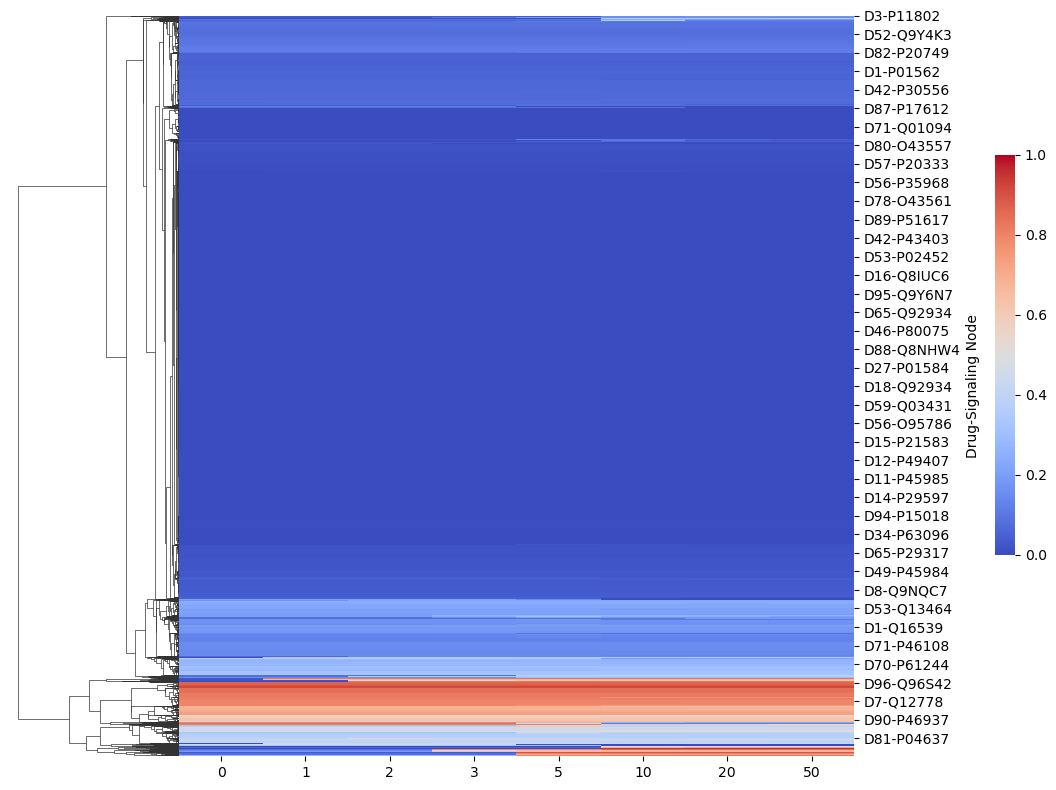

In [ ]:
sns.clustermap(
    synthetic_data_singlecellline, 
    cmap='coolwarm', 
    figsize=(10, 8), 
    col_cluster=False, 
    cbar_pos=(1, 0.3, .02, .5),
    dendrogram_ratio=(.2, 0), 
    vmin=0, 
    vmax=1)
plt.show()

c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


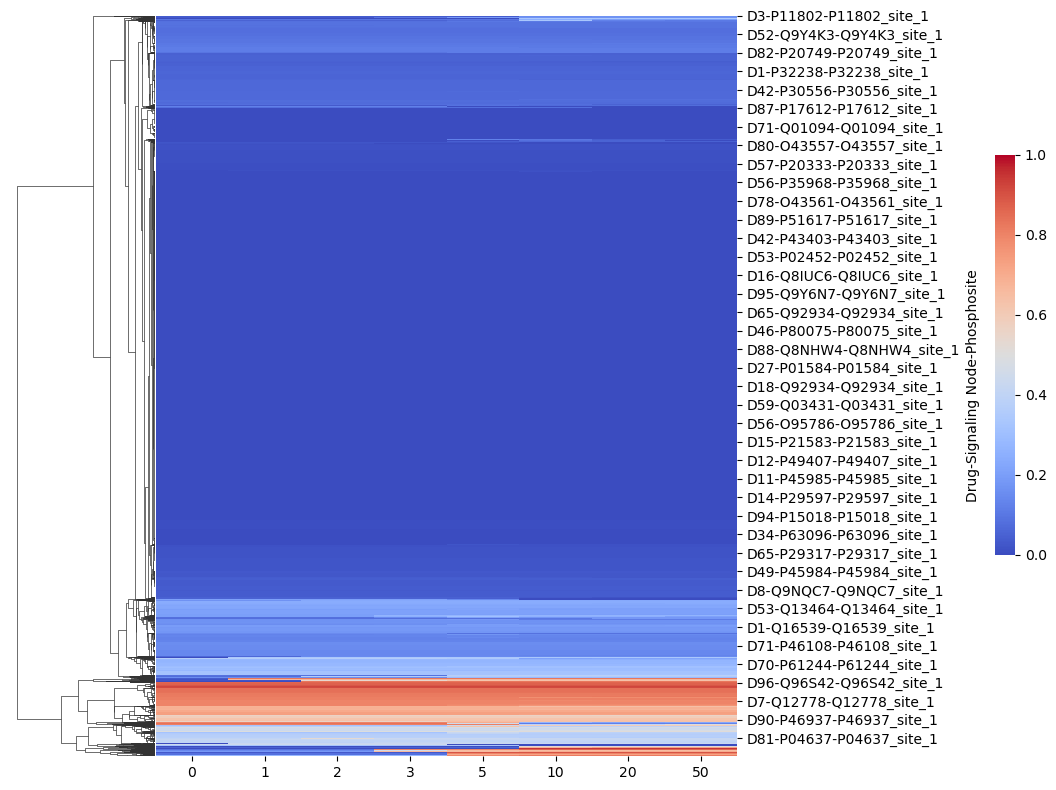

In [ ]:
sns.clustermap(
    synthetic_data_singlecellline_sim, 
    cmap='coolwarm', 
    figsize=(10, 8), 
    col_cluster=False, 
    cbar_pos=(1, 0.3, .02, .5),
    dendrogram_ratio=(.2, 0), 
    vmin=0, 
    vmax=1)
plt.show()

Genes of the X dataframe that are non-0: ['P01137', 'P08700', 'Q06643']


,Drug,Cell_line,Signaling Node,Time,Value
0,DMSO,CL0,Q13485,0,0.094610
1,DMSO,CL1,Q13485,0,0.128471
2,DMSO,CL3,Q13485,0,0.052933
3,DMSO,CL4,Q13485,0,0.195462
4,DMSO,CL5,Q13485,0,0.755289


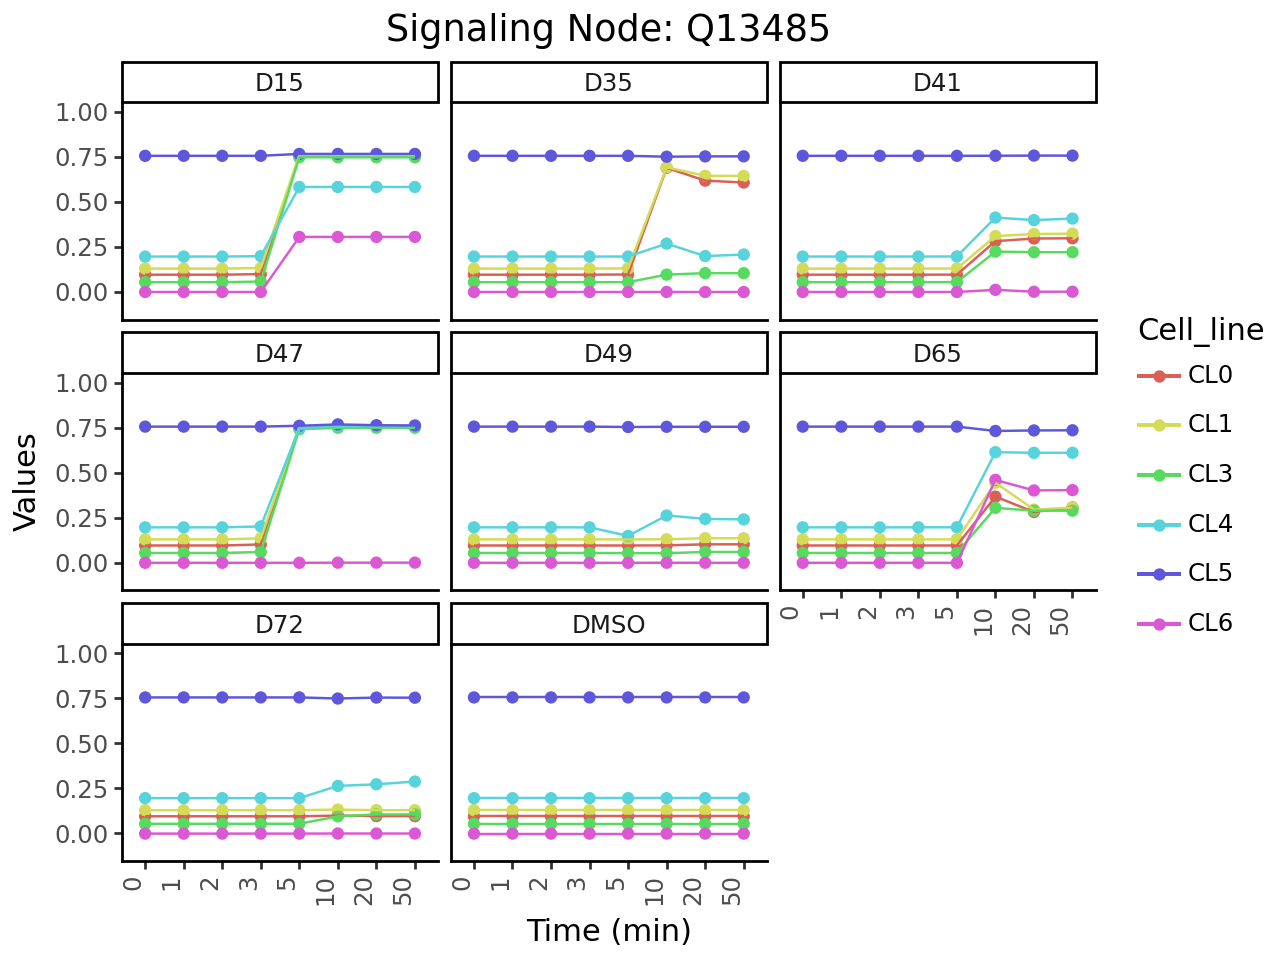

In [ ]:
X_D = X.xs('D15', level='Drug')
non_zero_columns = (X_D != 0).any(axis=0)
non_zero_column_names = non_zero_columns[non_zero_columns].index.tolist()
print(f"Genes of the X dataframe that are non-0: {non_zero_column_names}")

signaling_node = 'Q13485'  #P01137, P37173, P36897, Q15796  #Q13485

idx = pandas.IndexSlice
specific_rows = synthetic_data_plot.loc[idx[:, :, signaling_node], :]
specific_rows = specific_rows.reset_index()
specific_rows = specific_rows.melt(id_vars=['Drug', 'Cell_line', 'Signaling Node'], var_name='Time', value_name='Value')
display(specific_rows.head())

plot = (p9.ggplot(specific_rows, p9.aes(x='Time', y='Value', color='Cell_line', group='Cell_line'))
        + p9.geom_point()
        + p9.geom_line()
        + p9.facet_wrap('~Drug')
        + p9.labs(title=f'Signaling Node: {signaling_node}', x='Time (min)', y='Values')
        + p9.scale_y_continuous(limits=(-0.1, 1))
        + p9.theme_classic()
        + p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1)))

plot.show()

Plot the Cell line variation (correlation between average and individual cell lines).

C:\Users\kanto\AppData\Local\Temp\ipykernel_16680\1415384147.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


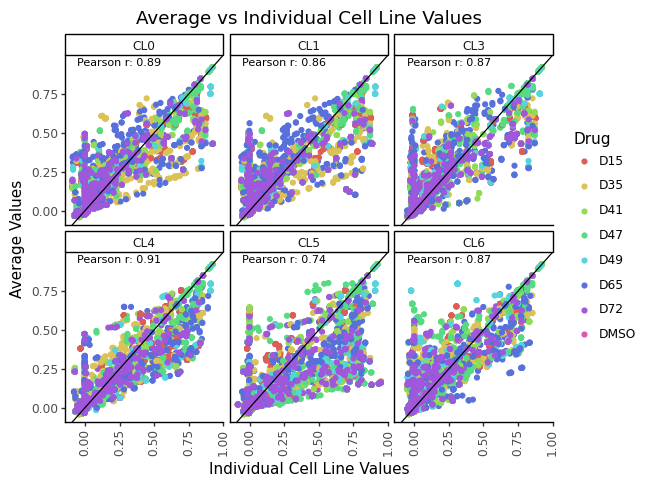

In [ ]:
# Long transform the data
synthetic_data_long = synthetic_data_plot.reset_index().melt(id_vars=['Drug', 'Cell_line', 'Signaling Node'], var_name='Time', value_name='Value')

# Calculate the average for each Drug/Time Point/Signaling Node across all Cell Lines
average_data = synthetic_data_long.groupby(['Drug', 'Time', 'Signaling Node'])['Value'].mean().reset_index()
average_data = average_data.rename(columns={'Value': 'Average'})
merged_data = pandas.merge(synthetic_data_long, average_data, on=['Drug', 'Time', 'Signaling Node'])

# Calculate Pearson correlation for each cell line against the average
def add_pearson_corr(data):
    corr, _ = pearsonr(data['Value'], data['Average'])
    return pandas.DataFrame({'Pearson Corr': [round(corr, 2)]})

corr_data = merged_data.groupby(['Cell_line']).apply(add_pearson_corr).reset_index()

plot = (p9.ggplot(merged_data, p9.aes(x='Value', y='Average', color='Drug'))
        + p9.geom_point()
        + p9.geom_abline()
        + p9.facet_wrap('~Cell_line')
        + p9.labs(title='Average vs Individual Cell Line Values', x='Individual Cell Line Values', y='Average Values')
        + p9.theme_classic()
        + p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=0.5))
        + p9.annotate('text', x=0.25, y=0.95, label='Pearson r: ' + corr_data['Pearson Corr'].astype(str), ha='center', va='center', size=8))

plot.draw()

Pairwise correlation between cell lines.

Cell_line,CL0,CL1,CL3,CL4,CL5,CL6
Cell_line,,,,,,
CL0,1.0,0.92,0.86,0.69,0.45,0.7
CL1,0.92,1.0,0.79,0.64,0.43,0.67
CL3,0.86,0.79,1.0,0.7,0.46,0.7
CL4,0.69,0.64,0.7,1.0,0.75,0.86
CL5,0.45,0.43,0.46,0.75,1.0,0.58
CL6,0.7,0.67,0.7,0.86,0.58,1.0


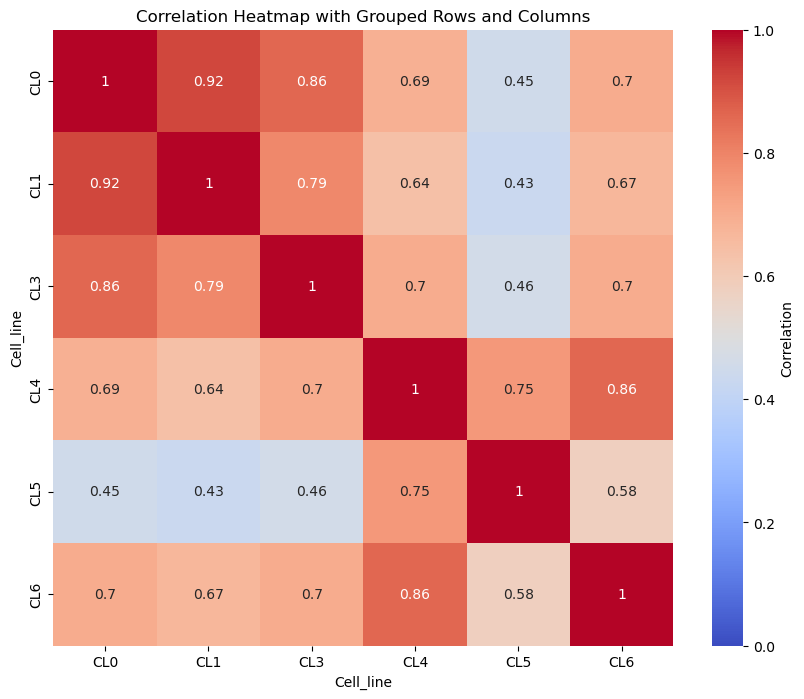

In [ ]:
synthetic_data_long = synthetic_data_plot.reset_index().melt(id_vars=['Drug', 'Cell_line', 'Signaling Node'], var_name='Time', value_name='Value')
pivot_data = synthetic_data_long.pivot_table(index=['Drug', 'Time', 'Signaling Node'], columns='Cell_line', values='Value').reset_index()

# Calculate Pearson correlation for each pair of cell lines
cell_lines = pivot_data.columns[3:]  # Skip the first three columns (Drug, Time, Signaling Node)
corr_data = pandas.DataFrame(index=cell_lines, columns=cell_lines)

for cell_line1 in cell_lines:
    for cell_line2 in cell_lines:
        if cell_line1 != cell_line2:
            corr, _ = pearsonr(pivot_data[cell_line1], pivot_data[cell_line2])
            corr_data.loc[cell_line1, cell_line2] = round(corr, 2)
        else:
            corr_data.loc[cell_line1, cell_line2] = 1.0

display(corr_data)
corr_data = corr_data.astype(float)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Heatmap with Grouped Rows and Columns')
plt.show()

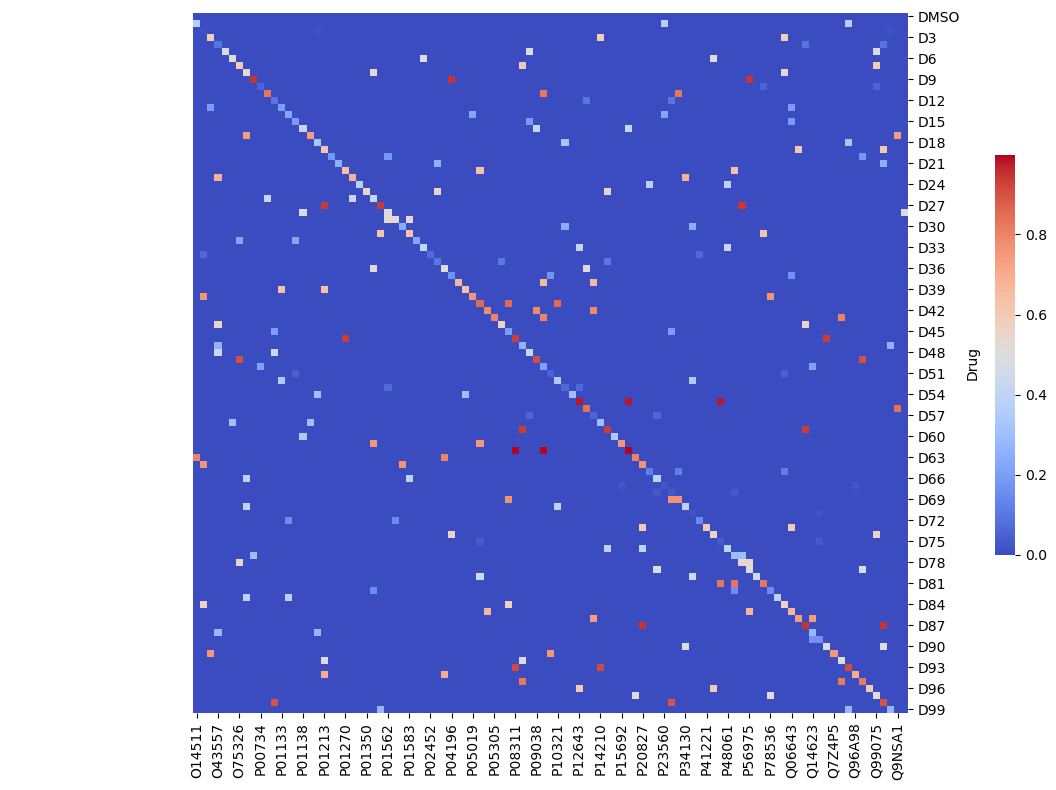

In [ ]:
X_CL0 = X.xs('CL0', level='Cell_line')
sns.clustermap(
    X_CL0, 
    cmap='coolwarm', 
    figsize=(10, 8), 
    col_cluster=False, 
    row_cluster=False,
    cbar_pos=(1, 0.3, .02, .5),
    dendrogram_ratio=(.2, 0))
plt.show()

## Create X_drug & Update X

In [ ]:
drug_targets = X_filtered.columns
drugs = X_filtered.index.get_level_values('Drug').unique()

# Initialize the one-hot encoded DataFrame
X_drugs = pandas.DataFrame(0, index=drug_targets, columns=drugs)

# Populate the one-hot encoded DataFrame
for drug in drugs:
    targets = X_filtered.loc[drug].columns[X_filtered.loc[drug].any()]
    X_drugs.loc[targets, drug] = 1

X_d =  pandas.DataFrame(index=X_filtered.index, columns=drugs)

# Populate the new DataFrame
for drug in drugs:
    X_d.loc[(drug, slice(None)), drug] = X_filtered.loc[(drug, slice(None)), :].max(axis=1).values
X_d = X_d.fillna(0)

display(X_drugs.head())
display(X_d.head())

C:\Users\kanto\AppData\Local\Temp\ipykernel_16680\1126212582.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


Drug,DMSO,D15,D35,D41,D47,D49,D65,D72
O14511,0,0,0,0,0,0,0,0
O14788,0,0,0,0,0,0,0,0
O14944,0,0,0,0,0,0,0,0
O43557,0,0,0,0,1,0,0,0
O75093,0,0,0,0,0,0,0,0


Drug            DMSO  D15  D35  D41  D47  D49  D65  D72
Drug Cell_line                                         
DMSO CL0         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
     CL1         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
     CL3         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
     CL4         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
     CL5         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

## Process Data to be Exported

Reformat `fullYFull` in order to have common Drug_CL_Time index and Genes as columns. Also, store mapping dataset (Drug_CL_Time -> Time point), so we can track which Drug_CL_Time maps to which Y time point when calculating the loss for the toy-model.

In [ ]:
# Create mapping between Signaling Nodes and Phosphosites
nodes_sites_df = synthetic_data_filtered.reset_index()[['Signaling Node', 'Phosphosite']].copy()
pivot_table = nodes_sites_df.pivot_table(index='Phosphosite', columns='Signaling Node', aggfunc='size', fill_value=0)
# Convert counts to binary (1 where a match exists, 0 where there is no match)
nodes_sites_df = pivot_table.apply(lambda x: x.map(lambda y: 1 if y > 0 else 0))

# Process Data
synthetic_data_melted = synthetic_data_filtered.reset_index().drop(columns=['Signaling Node']).melt(id_vars=['Drug', 'Cell_line', 'Phosphosite'], var_name='Time point', value_name='Value')
synthetic_data_melted['Drug_CL_Time'] = synthetic_data_melted['Drug'].astype(str) + '_' + synthetic_data_melted['Cell_line'].astype(str) + '_' + synthetic_data_melted['Time point'].astype(str)
synthetic_data_pivoted = synthetic_data_melted.pivot(index='Drug_CL_Time', columns='Phosphosite', values='Value')
synthetic_data_final = synthetic_data_melted[['Drug_CL_Time', 'Time point']].drop_duplicates().set_index('Drug_CL_Time')
synthetic_data_final = synthetic_data_final.merge(synthetic_data_pivoted, left_index=True, right_index=True)

synthetic_data_melted_full = synthetic_data.reset_index().drop(columns=['Signaling Node']).melt(id_vars=['Drug', 'Cell_line', 'Phosphosite'], var_name='Time point', value_name='Value')
synthetic_data_melted_full['Drug_CL_Time'] = synthetic_data_melted_full['Drug'].astype(str) + '_' + synthetic_data_melted_full['Cell_line'].astype(str) + '_' + synthetic_data_melted_full['Time point'].astype(str)
synthetic_data_pivoted_full = synthetic_data_melted_full.pivot(index='Drug_CL_Time', columns='Phosphosite', values='Value')
synthetic_data_final_full = synthetic_data_melted_full[['Drug_CL_Time', 'Time point']].drop_duplicates().set_index('Drug_CL_Time')
synthetic_data_final_full = synthetic_data_final_full.merge(synthetic_data_pivoted_full, left_index=True, right_index=True)

# Create a new mapping-dataset with Drug_CL_Time and Time point
condition_time_df = synthetic_data_final[['Time point']].reset_index()

synthetic_data_final.drop(columns=['Time point'], inplace=True)  # Delete Time point column from the synthetic dataset
synthetic_data_final_full.drop(columns=['Time point'], inplace=True)

display(nodes_sites_df.head())
display(condition_time_df.head())
display(synthetic_data_final.head())
display(synthetic_data_final_full.head())

Signaling Node,O00206,O14492,O14511,O14640,O14727,O14733,O14763,O14788,O14920,O14944,...,Q9UPT6,Q9UQC2,Q9Y243,Q9Y2X7,Q9Y4D1,Q9Y4H2,Q9Y4K3,Q9Y6K9,Q9Y6N7,Q9Y6Q6
Phosphosite,,,,,,,,,,,,,,,,,,,,,
O00206_site_1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O14492_site_1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O14511_site_1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O14640_site_1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O14727_site_1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,Drug_CL_Time,Time point
0,DMSO_CL0_0,0
1,DMSO_CL1_0,0
2,DMSO_CL3_0,0
3,DMSO_CL4_0,0
4,DMSO_CL5_0,0


,O00206_site_1,O14492_site_1,O14511_site_1,O14640_site_1,O14727_site_1,O14733_site_1,O14763_site_1,O14788_site_1,O14920_site_1,O14944_site_1,...,Q9UPT6_site_1,Q9UQC2_site_1,Q9Y243_site_1,Q9Y2X7_site_1,Q9Y4D1_site_1,Q9Y4H2_site_1,Q9Y4K3_site_1,Q9Y6K9_site_1,Q9Y6N7_site_1,Q9Y6Q6_site_1
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
DMSO_CL0_0,-0.000015,0.020825,0.011471,-0.000306,-4.138773e-06,-0.001381,-0.000232,-0.056011,-0.073912,0.009005,...,-0.000772,0.067905,0.085681,0.291787,0.050199,-0.002244,0.083416,-0.002446,-0.000151,0.016787
DMSO_CL1_0,-0.000015,0.020820,0.011471,-0.000306,-2.757322e-06,-0.001370,-0.000232,-0.037347,-0.050963,0.009005,...,-0.000615,0.068163,0.057446,0.294335,0.050199,-0.002439,0.057259,-0.002230,-0.000151,-0.001998
DMSO_CL3_0,-0.000015,0.015383,0.011471,-0.000306,-9.825285e-07,-0.001236,-0.003692,-0.018682,-0.027992,0.009005,...,-0.001402,0.125586,-0.020024,0.271188,0.050199,-0.001486,0.125180,-0.002792,-0.000151,0.044954
DMSO_CL4_0,-0.000057,0.020825,0.011471,-0.000306,1.837949e-06,-0.001254,-0.000232,-0.000018,-0.004979,0.009005,...,-0.000804,0.068902,-0.005048,0.291358,0.050199,-0.002214,0.134309,-0.002867,-0.000154,0.059037
DMSO_CL5_0,0.451672,0.020825,0.011471,-0.000306,2.271277e-06,0.005224,-0.000147,-0.000018,-0.004641,0.009005,...,0.004758,0.071094,-0.001128,0.294590,0.050199,-0.003247,0.601453,-0.006721,-0.000153,0.059037


,O00206_site_1,O14492_site_1,O14511_site_1,O14640_site_1,O14727_site_1,O14733_site_1,O14763_site_1,O14788_site_1,O14920_site_1,O14944_site_1,...,Q9UPT6_site_1,Q9UQC2_site_1,Q9Y243_site_1,Q9Y2X7_site_1,Q9Y4D1_site_1,Q9Y4H2_site_1,Q9Y4K3_site_1,Q9Y6K9_site_1,Q9Y6N7_site_1,Q9Y6Q6_site_1
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
DMSO_CL0_0,-0.000015,0.020825,0.011471,-0.000306,-4.138773e-06,-0.001381,-0.000232,-0.056011,-0.073912,0.009005,...,-0.000772,0.067905,0.085681,0.291787,0.050199,-0.002244,0.083416,-0.002446,-0.000151,0.016787
DMSO_CL1_0,-0.000015,0.020820,0.011471,-0.000306,-2.757322e-06,-0.001370,-0.000232,-0.037347,-0.050963,0.009005,...,-0.000615,0.068163,0.057446,0.294335,0.050199,-0.002439,0.057259,-0.002230,-0.000151,-0.001998
DMSO_CL3_0,-0.000015,0.015383,0.011471,-0.000306,-9.825285e-07,-0.001236,-0.003692,-0.018682,-0.027992,0.009005,...,-0.001402,0.125586,-0.020024,0.271188,0.050199,-0.001486,0.125180,-0.002792,-0.000151,0.044954
DMSO_CL4_0,-0.000057,0.020825,0.011471,-0.000306,1.837949e-06,-0.001254,-0.000232,-0.000018,-0.004979,0.009005,...,-0.000804,0.068902,-0.005048,0.291358,0.050199,-0.002214,0.134309,-0.002867,-0.000154,0.059037
DMSO_CL5_0,0.451672,0.020825,0.011471,-0.000306,2.271277e-06,0.005224,-0.000147,-0.000018,-0.004641,0.009005,...,0.004758,0.071094,-0.001128,0.294590,0.050199,-0.003247,0.601453,-0.006721,-0.000153,0.059037


In [ ]:
X_final = X_d.copy()
X_final['Drug_CL'] = X_final.index.get_level_values('Drug') + '_' + X_final.index.get_level_values('Cell_line')
X_final.set_index('Drug_CL', inplace=True)
X_final.index.name = 'Drug_CL'
display(X_final.head())

X_cell_final = X_cell.copy()
X_cell_final['Drug_CL'] = X_cell_final.index.get_level_values('Drug') + '_' + X_cell_final.index.get_level_values('Cell_line')
X_cell_final.set_index('Drug_CL', inplace=True)
X_cell_final.index.name = 'Drug_CL'
display(X_cell_final.head())

Drug,DMSO,D15,D35,D41,D47,D49,D65,D72
Drug_CL,,,,,,,,
DMSO_CL0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DMSO_CL1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DMSO_CL3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DMSO_CL4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DMSO_CL5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cell_line,CL0,CL1,CL3,CL4,CL5,CL6
Drug_CL,,,,,,
DMSO_CL0,1,0,0,0,0,0
DMSO_CL1,0,1,0,0,0,0
DMSO_CL3,0,0,1,0,0,0
DMSO_CL4,0,0,0,1,0,0
DMSO_CL5,0,0,0,0,1,0


## Z-score Scale Data

In [ ]:
phosphosite_cols = synthetic_data_final.columns.tolist()

In [ ]:
'''synthetic_data_final[phosphosite_cols] = synthetic_data_final[phosphosite_cols].apply(zscore)
synthetic_data_final_full[phosphosite_cols] = synthetic_data_final_full[phosphosite_cols].apply(zscore)'''

'synthetic_data_final[phosphosite_cols] = synthetic_data_final[phosphosite_cols].apply(zscore)\nsynthetic_data_final_full[phosphosite_cols] = synthetic_data_final_full[phosphosite_cols].apply(zscore)'

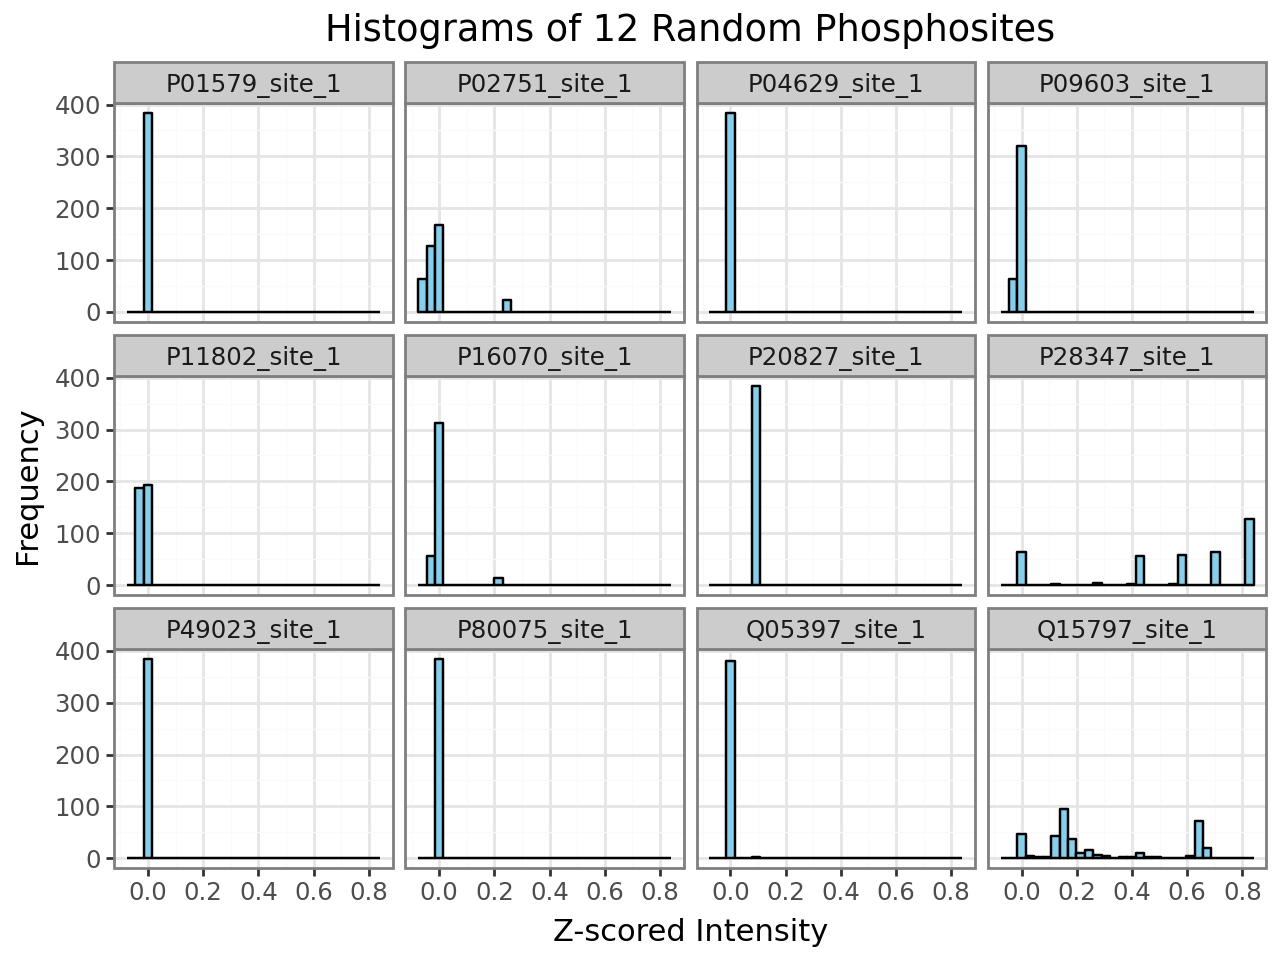

In [ ]:
# Visualize distributions of 12 random phosphosites to check
random_sites = numpy.random.choice(phosphosite_cols, size=12, replace=False)

synthetic_data_plot = synthetic_data_final.copy().reset_index()
df_long = pandas.melt(synthetic_data_plot,
                      id_vars=['Drug_CL_Time'], 
                      value_vars=random_sites,
                      var_name='Phosphosite', 
                      value_name='Intensity')

p = (p9.ggplot(df_long, p9.aes(x='Intensity'))
     + p9.geom_histogram(bins=30, fill="skyblue", color="black")
     + p9.facet_wrap('~Phosphosite')
     + p9.theme_bw()
     + p9.labs(title="Histograms of 12 Random Phosphosites",
               x="Z-scored Intensity", y="Frequency")
    )
p.show()

## Simulate Missing Information

We simulate the scenario that there are genes from the PKN that are not in the synthetic data. We do that by dropping a specified percentage of random columns from the dataset. We also simulate the introduction of missing values to the synthetic dataset. A dictionary with column/variable percentages as keys and missing value percentages as values is required. Both column selection and missing value introduction is done randomly.

In [ ]:
def drop_random_nodes_and_sites(df, nodes_sites_map, percentage):
    """
    Drop a given percentage of nodes and all their corresponding sites from the DataFrame.
    
    Args:
        df (pandas.DataFrame): The input DataFrame with sites as columns.
        nodes_sites_map (pandas.DataFrame): The DataFrame mapping nodes to sites.
        percentage (float): The percentage of nodes to drop (between 0 and 100).
    
    Returns:
        pandas.DataFrame: The DataFrame with the specified percentage of nodes and their corresponding sites dropped.
    """
    
    # Calculate the number of nodes to drop and select them randomly
    num_nodes_to_drop = int(len(nodes_sites_map.columns) * (percentage / 100))
    nodes_to_drop = numpy.random.choice(nodes_sites_map.columns, num_nodes_to_drop, replace=False)
    
    # Get all corresponding sites for the selected nodes
    sites_to_drop = nodes_sites_map.index[nodes_sites_map[nodes_to_drop].any(axis=1)].tolist()

    # Drop the corresponding sites from the DataFrame
    df_dropped = df.drop(columns=sites_to_drop)
    
    return df_dropped, nodes_to_drop, sites_to_drop


def add_missing_values(df, missing_dict):
    """
    Add missing values to a DataFrame based on specified percentages.

    Args:
        df (pandas.DataFrame): The input DataFrame to which missing values will be added.
        missing_dict (dict): A dictionary where keys are percentages of columns to be affected,
        and values are percentages of missing values to be introduced in those columns.

    Returns:
        pandas.DataFrame: The DataFrame with missing values added.

    Raises:
        ValueError: If the sum of the keys in missing_dict exceeds 100.
    """
    numpy.random.seed(123)
    
    # Check if the keys sum up to 100
    if sum(missing_dict.keys()) < 100:
        print("Warning: The percentage of dataset columns sum up to less than 100. The rest of the dataset will remain unchanged.")
    elif sum(missing_dict.keys()) > 100:
        raise ValueError("Error: The percentage of dataset columns sum up to more than 100. Please adjust the percentages.")

    num_columns = df.shape[1]
    columns = df.columns.tolist()
    numpy.random.shuffle(columns)

    start_idx = 0
    for key, value in missing_dict.items():
        num_cols = int(num_columns * (key / 100))  # Calculate the number of columns for this percentage
        subset_columns = columns[start_idx:start_idx + num_cols]

        # Apply missing values to the subset of columns
        for col in subset_columns:
            num_missing = int(df.shape[0] * (value / 100))
            missing_indices = numpy.random.choice(df.index, num_missing, replace=False)
            df.loc[missing_indices, col] = numpy.nan

        start_idx += num_cols

    return df

print(f'Number of cols before dropping: {len(synthetic_data_final.columns)}')
#synthetic_data_final, nodes_to_drop, sites_to_drop = drop_random_nodes_and_sites(synthetic_data_final, nodes_sites_df, 20)
print(f'Number of cols after dropping: {len(synthetic_data_final.columns)}')

# Drop the selected nodes from the nodes_sites_df DataFrame
print(f'Before dropping | Protein number: {len(nodes_sites_df.columns)}, Site number: {len(nodes_sites_df.index.tolist())}')
#nodes_sites_df = nodes_sites_df.drop(columns=nodes_to_drop)
#nodes_sites_df = nodes_sites_df.drop(index=sites_to_drop)
print(f'After dropping | Protein number: {len(nodes_sites_df.columns)}, Site number: {len(nodes_sites_df.index.tolist())}')

missing_dict = {10: 80, 30: 60, 40: 30, 20: 0}  #{100: 0}
#synthetic_data_final = add_missing_values(synthetic_data_final, missing_dict)
display(synthetic_data_final)

Number of cols before dropping: 409
Number of cols after dropping: 328
Before dropping | Protein number: 409, Site number: 409
After dropping | Protein number: 328, Site number: 328


,O00206_site_1,O14492_site_1,O14511_site_1,O14640_site_1,O14727_site_1,O14733_site_1,O14763_site_1,O14788_site_1,O14920_site_1,O14944_site_1,...,Q9ULW2_site_1,Q9UMX1_site_1,Q9UPT6_site_1,Q9UQC2_site_1,Q9Y243_site_1,Q9Y2X7_site_1,Q9Y4D1_site_1,Q9Y4H2_site_1,Q9Y4K3_site_1,Q9Y6N7_site_1
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
DMSO_CL0_0,NaN,0.020825,0.011471,-0.000306,-0.000004,NaN,NaN,-0.056011,-0.073912,NaN,...,NaN,-0.001529,NaN,NaN,0.085681,0.291787,0.050199,-0.002244,NaN,-0.000151
DMSO_CL1_0,NaN,0.020820,0.011471,-0.000306,-0.000003,NaN,-0.000232,-0.037347,-0.050963,NaN,...,-0.000093,-0.001529,-0.000615,0.068163,0.057446,0.294335,0.050199,NaN,NaN,-0.000151
DMSO_CL3_0,-0.000015,0.015383,0.011471,-0.000306,NaN,NaN,-0.003692,NaN,NaN,NaN,...,NaN,-0.001529,-0.001402,0.125586,-0.020024,0.271188,0.050199,NaN,NaN,-0.000151
DMSO_CL4_0,-0.000057,0.020825,0.011471,-0.000306,0.000002,NaN,-0.000232,-0.000018,-0.004979,NaN,...,-0.000093,NaN,NaN,0.068902,-0.005048,0.291358,0.050199,NaN,NaN,-0.000154
DMSO_CL5_0,0.451672,0.020825,0.011471,-0.000306,0.000002,NaN,NaN,-0.000018,-0.004641,0.009005,...,-0.000093,-0.001528,NaN,NaN,-0.001128,NaN,NaN,-0.003247,NaN,-0.000153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D72_CL1_50,-0.000015,0.020820,0.011471,-0.000306,NaN,NaN,-0.000232,NaN,-0.050963,NaN,...,NaN,-0.001529,NaN,0.068323,0.067655,NaN,0.050199,NaN,NaN,-0.000151
D72_CL3_50,-0.000015,0.015383,0.011471,-0.000306,NaN,NaN,-0.003692,NaN,-0.027992,0.009005,...,-0.000093,-0.001529,NaN,NaN,-0.019462,0.279410,NaN,-0.001770,NaN,-0.000151
D72_CL4_50,-0.000057,0.020825,0.011471,-0.000306,0.000002,-0.001252,NaN,NaN,-0.004979,0.009005,...,-0.000093,-0.001528,-0.000576,NaN,-0.004604,NaN,NaN,-0.002491,0.133199,-0.000154


## Export Data

In [ ]:
synthetic_data_final.to_csv('data/synthetic_data_y.csv', index=True)
synthetic_data_final_full.to_csv('data/synthetic_data_y_full.csv', index=True)
X_final.to_csv('data/synthetic_data_x.csv', index=True)
X_cell_final.to_csv('data/synthetic_data_xcell.csv', index=True)
X_drugs.to_csv('data/synthetic_data_xdrug.csv', index=True)
nodes_sites_df.to_csv('data/nodes_sites_map.csv', index=True)